In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

In [4]:
df = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.HasCrCard.value_counts()

HasCrCard
1    7055
0    2945
Name: count, dtype: int64

In [6]:
7055 / df.shape[0]

0.7055

In [7]:
df.drop('CustomerId', axis='columns', inplace=True)

In [8]:
df.dtypes

RowNumber            int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [9]:
df.isna().sum()

RowNumber          0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

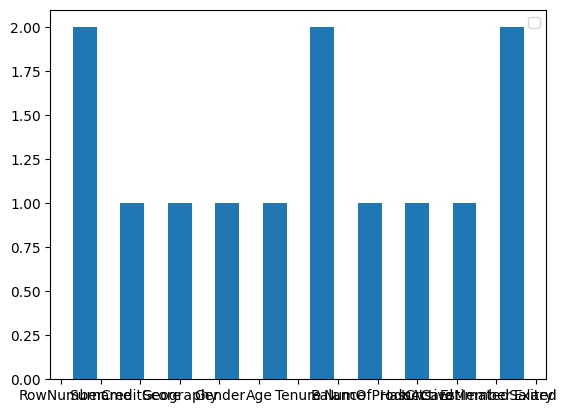

In [10]:
has_card = df[df.HasCrCard == 1].HasCrCard
hasnot_card = df[df.HasCrCard == 0].HasCrCard

plt.hist(df.columns, rwidth = 0.5)
plt.legend()

In [11]:
hasnot_card.shape

(2945,)

In [12]:
df.replace('Female', '1', inplace=True)
df.replace('Male', '0', inplace=True)

In [13]:
df.sample(5)

,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9316,9317,Lettiere,550,Germany,0,49,0,108806.96,3,1,0,61446.92,1
2882,2883,McKay,551,France,0,37,3,0.00,2,1,1,50578.40,0
1169,1170,Millar,653,France,1,38,8,102133.38,1,1,1,166520.96,0
7299,7300,Lettiere,661,France,0,51,6,146606.60,1,1,1,68021.90,0
9546,9547,Chizoba,524,France,0,29,7,0.00,2,1,1,105448.74,0


In [14]:
df.NumOfProducts.value_counts()

NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

In [15]:
df.replace('France', '0', inplace=True)
df.replace('Germany', '1', inplace=True)
df.replace('Spain', '2', inplace=True)

In [16]:
df.drop('Surname', axis='columns', inplace=True)

In [17]:
 df[['Geography', 'Gender']] = df[['Geography', 'Gender']].apply(pd.to_numeric)

In [18]:
df.dtypes

RowNumber            int64
CreditScore          int64
Geography            int64
Gender               int64
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [19]:
df.sample(5)

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7686,7687,718,0,0,48,9,0.00,2,1,1,72105.63,0
488,489,692,0,0,30,2,0.00,2,0,1,130486.57,0
7,8,376,1,1,29,4,115046.74,4,1,0,119346.88,1
3080,3081,468,2,0,28,3,0.00,2,1,0,170661.02,0
8862,8863,813,1,0,59,2,135078.41,1,1,0,187636.06,1


In [20]:

from sklearn.model_selection import train_test_split

x = df.drop('Exited', axis='columns')
y = df['Exited']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
y_train.shape

(8000,)

In [22]:
len(x_train.columns)


11

In [58]:
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
df_train = df
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)


df_train = df_train.drop(scale_cols, axis=1)
df_train.head()

,RowNumber,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled
0,1,0,1,2,1,1,1,1,0.324324,0.538,0.000000,0.506735
1,2,2,1,1,1,0,1,0,0.310811,0.516,0.334031,0.562709
2,3,0,1,8,3,1,0,1,0.324324,0.304,0.636357,0.569654
3,4,0,1,1,2,0,0,0,0.283784,0.698,0.000000,0.469120
4,5,2,1,2,1,1,1,0,0.337838,1.000,0.500246,0.395400


In [59]:
import sys
!{sys.executable} -m pip install -q tensorflow-addons

# Then in your code
from tensorflow_addons import losses

from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

def ANN(x_train, y_train, x_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(11, input_dim=11, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    if weights == -1:
        model.fit(x_train, y_train, epochs=100)
    else:
        model.fit(x_train, y_train, epochs=100, class_weights = weights)
        
    print(model.evaluate(x_test, y_test))
    
    y_preds = model.predict(x_test)
    y_pred = np.round(y_preds)
    
    print('report: \n', classification_report(y_test, y_pred))
    
    return y_pred

Undersampling


In [60]:
class_0 = df_train[df_train['Exited'] == 0]
class_1 = df_train[df_train['Exited'] == 1]

In [61]:
class_0.shape[0]

7963

In [62]:
class_1.shape[0]

2037

In [63]:
class_0_under = class_0.sample(class_1.shape[0])
class_0_under.shape

(2037, 12)

In [93]:
df_under = pd.concat([class_0_under, class_1], axis=0)

x = df_under.drop('Exited', axis='columns')
y = df_under['Exited']

x_train, x_test, y_train, y_test1 = train_test_split(x, y, test_size=0.2, random_state=15, stratify=y)

In [65]:
len(x_train.columns)

11

In [66]:
y_train.value_counts()

Exited
1    1630
0    1629
Name: count, dtype: int64

In [67]:
y_pred1 = ANN(x_train, y_train, x_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
102/102 [==============================] - 1s 2ms/step - loss: 96.4948 - accuracy: 0.5063
Epoch 2/100
102/102 [==============================] - 0s 2ms/step - loss: 0.9178 - accuracy: 0.5035
Epoch 3/100
102/102 [==============================] - 0s 2ms/step - loss: 0.8778 - accuracy: 0.5060
Epoch 4/100
102/102 [==============================] - 0s 2ms/step - loss: 1.0657 - accuracy: 0.4977
Epoch 5/100
102/102 [==============================] - 0s 2ms/step - loss: 0.9691 - accuracy: 0.5115
Epoch 6/100
102/102 [==============================] - 0s 3ms/step - loss: 1.0560 - accuracy: 0.5164
Epoch 7/100
102/102 [==============================] - 0s 2ms/step - loss: 0.9762 - accuracy: 0.5130
Epoch 8/100
102/102 [==============================] - 0s 2ms/step - loss: 1.1517 - accuracy: 0.5054
Epoch 9/100
102/102 [==============================] - 0s 3ms/step - loss: 0.9029 - accuracy: 0.5167
Epoch 10/100
102/102 [==============================] - 0s 3ms/step - loss: 1.0127 - accur

Oversampling

In [68]:
class_1_over = class_1.sample(class_0.shape[0], replace=True)
class_1_over.shape


(7963, 12)

In [69]:
class_0.shape

(7963, 12)

In [70]:
df_over = pd.concat([class_1_over, class_0], axis=0)
df_over.head()

,RowNumber,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled
5369,5370,2,0,8,1,0,0,1,0.459459,0.450,0.493927,0.556709
399,400,0,1,1,1,1,0,1,0.648649,0.532,0.541425,0.919232
9045,9046,1,0,5,1,1,0,1,0.121622,0.832,0.503335,0.888098
5838,5839,2,0,3,1,0,0,1,0.445946,0.638,0.354038,0.426237
868,869,1,0,6,2,1,0,1,0.351351,0.506,0.430941,0.542436


In [71]:
df_over.Exited.value_counts()

Exited
1    7963
0    7963
Name: count, dtype: int64

In [72]:
x = df_over.drop('Exited', axis='columns')
y = df_over['Exited']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=15, stratify=y)
print(len(x_train.columns))
loss = keras.losses.BinaryCrossentropy()
weights = -1
y_pred2 = ANN(x_train, y_train, x_test, y_test, 'binary_crossentropy', -1)

11
Epoch 1/100
399/399 [==============================] - 2s 2ms/step - loss: 23.6278 - accuracy: 0.5029
Epoch 2/100
399/399 [==============================] - 1s 2ms/step - loss: 1.0551 - accuracy: 0.5152
Epoch 3/100
399/399 [==============================] - 1s 2ms/step - loss: 1.1101 - accuracy: 0.5151
Epoch 4/100
399/399 [==============================] - 1s 2ms/step - loss: 1.1494 - accuracy: 0.5177
Epoch 5/100
399/399 [==============================] - 1s 2ms/step - loss: 1.0348 - accuracy: 0.5316
Epoch 6/100
399/399 [==============================] - 1s 2ms/step - loss: 1.1320 - accuracy: 0.5413
Epoch 7/100
399/399 [==============================] - 1s 2ms/step - loss: 0.9904 - accuracy: 0.5443
Epoch 8/100
399/399 [==============================] - 1s 2ms/step - loss: 1.0023 - accuracy: 0.5522
Epoch 9/100
399/399 [==============================] - 1s 2ms/step - loss: 0.9976 - accuracy: 0.5465
Epoch 10/100
399/399 [==============================] - 1s 2ms/step - loss: 0.9638 - ac

SMOTE


In [76]:
x = df_train.drop('Exited', axis='columns')
y = df_train['Exited']

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')

x_sm, y_sm = smote.fit_resample(x, y)

y_sm.value_counts()

Exited
1    7963
0    7963
Name: count, dtype: int64

In [80]:
x_train.shape

(12740, 11)

In [81]:
x_train, x_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

y_pred3 = ANN(x_train, y_train, x_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
399/399 [==============================] - 2s 2ms/step - loss: 9.4127 - accuracy: 0.5036
Epoch 2/100
399/399 [==============================] - 1s 2ms/step - loss: 0.8585 - accuracy: 0.5290
Epoch 3/100
399/399 [==============================] - 1s 2ms/step - loss: 0.9393 - accuracy: 0.5400
Epoch 4/100
399/399 [==============================] - 1s 2ms/step - loss: 0.9046 - accuracy: 0.5692
Epoch 5/100
399/399 [==============================] - 1s 2ms/step - loss: 0.9244 - accuracy: 0.5716
Epoch 6/100
399/399 [==============================] - 1s 2ms/step - loss: 0.9426 - accuracy: 0.5844
Epoch 7/100
399/399 [==============================] - 1s 2ms/step - loss: 0.7866 - accuracy: 0.6053
Epoch 8/100
399/399 [==============================] - 1s 2ms/step - loss: 0.7395 - accuracy: 0.6196
Epoch 9/100
399/399 [==============================] - 1s 2ms/step - loss: 0.8202 - accuracy: 0.6106
Epoch 10/100
399/399 [==============================] - 1s 2ms/step - loss: 0.8633 - accura

In [85]:
y_pred_final = y_pred1.copy()
for i in range(len(y_pred1)):
    n = y_pred1[i] + y_pred2[i] + y_pred3[i]
    if n > 1:
        y_pred_final[i] = 1
    else:
        y_pred_final[i] = 0

In [88]:
y_test.shape

(3186,)

In [92]:
y_pred1.shape

(815, 1)

In [94]:
cl_rep = classification_report(y_test1, y_pred_final)
print(cl_rep)

              precision    recall  f1-score   support

           0       0.52      0.69      0.59       408
           1       0.54      0.36      0.43       407

    accuracy                           0.53       815
   macro avg       0.53      0.52      0.51       815
weighted avg       0.53      0.53      0.51       815

